**Projeto Final:** Análise exploratória dos dados

**Alunos:** Daniel de Souza Queiroga, Igor de Melo Xavier, Pedro Victor Eugenio Souza

**Disciplina:** IN1102 - APRENDIZAGEM DE MÁQUINA

**Professor:** Leandro Maciel Almeida

In [ ]:
!wget -q https://dansq.github.io/dataset_choral.csv

In [ ]:
pip install scikit-posthocs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install sklvq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 71 kB 5.1 MB/s 


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scikit_posthocs as sp

from scipy import stats

from sklvq import GLVQ
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV, \
                                    StratifiedKFold, train_test_split, cross_val_score

seed_value = 65879
import random
random.seed(seed_value)

from warnings import filterwarnings
filterwarnings('ignore')



In [ ]:
ds_path = '/content/dataset_choral.csv'
choral_df = pd.read_csv(ds_path)

In [ ]:
choral_df

,Choral ID,Event number,Pitch classe: C,Pitch classe: C#/Db,Pitch classe: D,Pitch classe: D#,Pitch classe: E,Pitch classe: F,Pitch classe: F#,Pitch classe: G,Pitch classe: G#,Pitch classe: A,Pitch classe: A#,Pitch classe: B,Bass,Meter,Chord label
0,000106b_,1,YES,NO,NO,NO,NO,YES,NO,NO,NO,YES,NO,NO,F,3,F_M
1,000106b_,2,YES,NO,NO,NO,YES,NO,NO,YES,NO,NO,NO,NO,E,5,C_M
2,000106b_,3,YES,NO,NO,NO,YES,NO,NO,YES,NO,NO,NO,NO,E,2,C_M
3,000106b_,4,YES,NO,NO,NO,NO,YES,NO,NO,NO,YES,NO,NO,F,3,F_M
4,000106b_,5,YES,NO,NO,NO,NO,YES,NO,NO,NO,YES,NO,NO,F,2,F_M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5660,015505b_,105,NO,NO,YES,NO,NO,NO,NO,YES,NO,NO,YES,NO,G,4,G_m
5661,015505b_,106,NO,NO,YES,NO,NO,NO,NO,YES,NO,YES,NO,NO,G,3,G_m
5662,015505b_,107,YES,NO,NO,NO,YES,NO,NO,YES,NO,NO,NO,NO,C,5,C_M
5663,015505b_,108,YES,NO,NO,NO,YES,NO,NO,YES,NO,NO,YES,NO,C,3,C_M


# Verificando a distribuição das classes reposta

In [ ]:
chords_frequencies = choral_df['Chord label'].value_counts()
chords_percentages = choral_df['Chord label'].value_counts(normalize = True) * 100

In [ ]:
df_freq_perc = pd.DataFrame({'frequency': chords_frequencies, 'percentage (%)': chords_percentages})
df_freq_perc 

,frequency,percentage (%)
D_M,503,8.879082
G_M,489,8.631951
C_M,488,8.614298
F_M,389,6.866726
A_M,352,6.213592
...,...,...
F_d7,1,0.017652
DbM7,1,0.017652
Ebd,1,0.017652
Abd,1,0.017652


In [ ]:
chords = ['D_M', 'G_M', 'C_M', 'F_M', 'A_M', 'BbM', 'E_M', 'A_m', 'E_m', 'B_m', 'G_m' ,'D_m', 'EbM', 'C_m', 'F#m', 'B_M', 'F#M', 'C_M7', 'D_M7', 'A_M7', 'G_M7', 'B_M7',
          'E_M7', 'F_m', 'C#M']

In [ ]:
new_df = choral_df['Chord label'].isin(chords)

In [ ]:
new_df

0       True
1       True
2       True
3       True
4       True
        ... 
5660    True
5661    True
5662    True
5663    True
5664    True
Name: Chord label, Length: 5665, dtype: bool

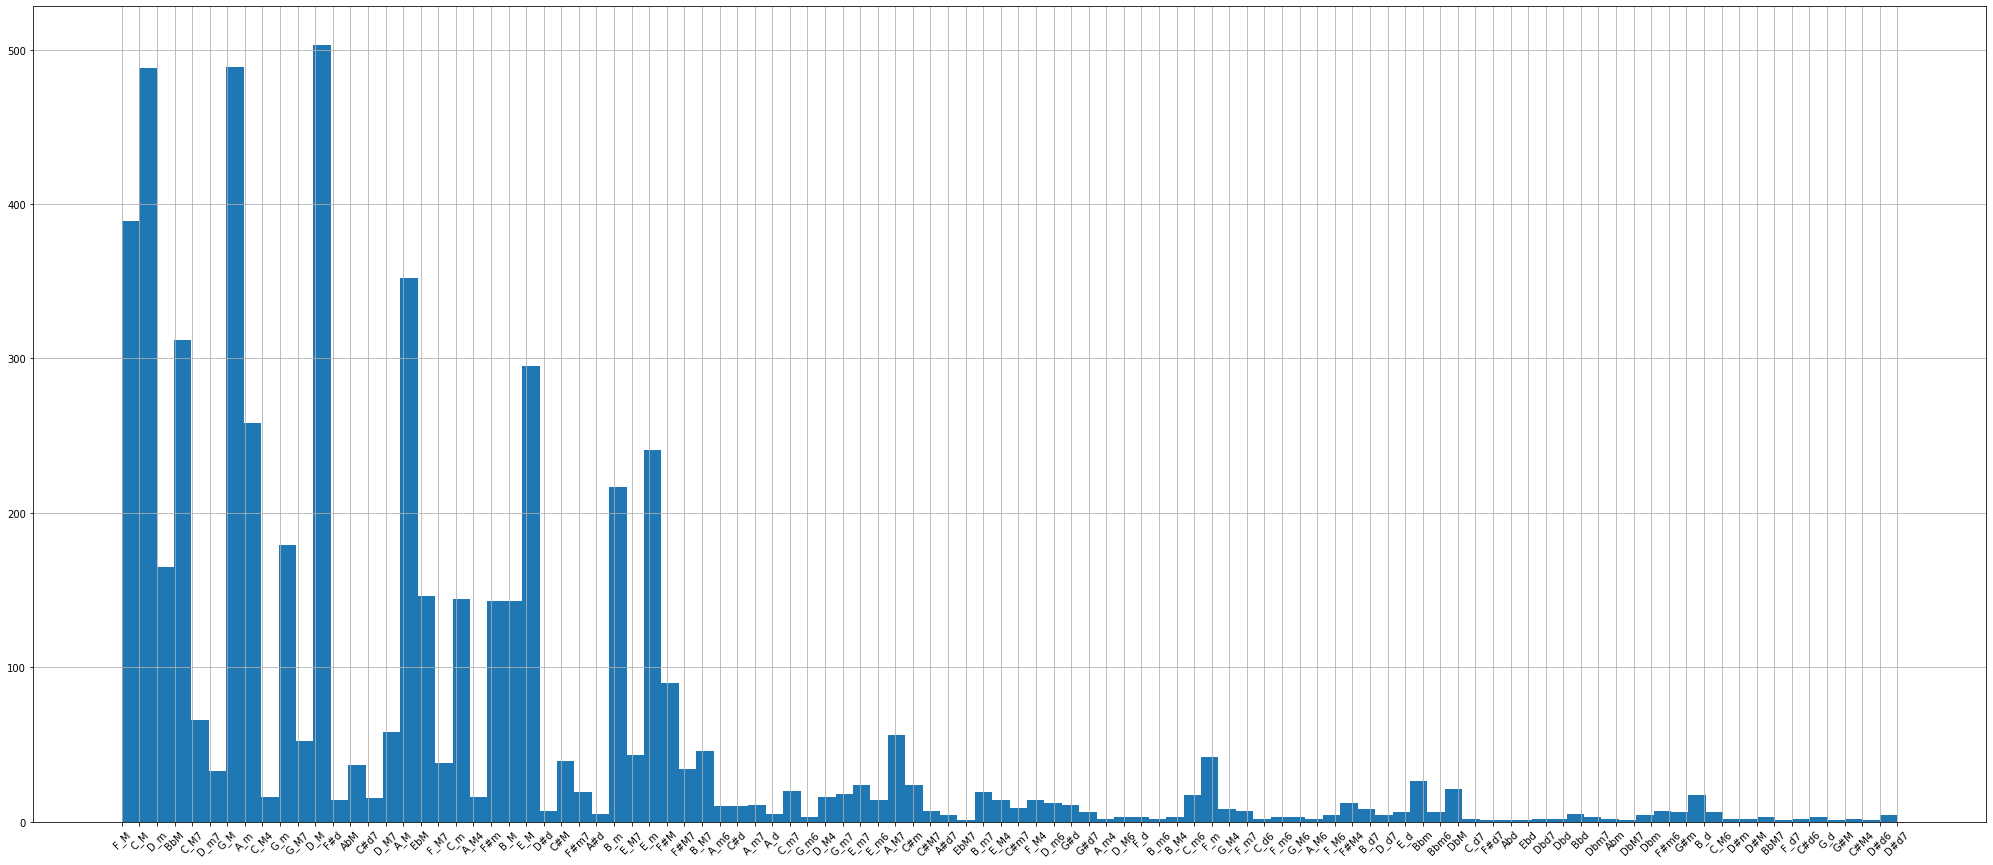

In [ ]:
choral_df['Chord label'].hist(figsize=(35,15),bins=102,xrot=45)

Podemos observar que a distribuição das classes das amostras não é muito equilibrada

In [ ]:
choral_df['Chord label'].describe()

count     5665
unique     102
top        D_M
freq       503
Name: Chord label, dtype: object

In [ ]:
freq = pd.crosstab(choral_df['Chord label'], choral_df['Bass'])
freq

Bass,A,A#,Ab,B,Bb,C,C#,D,D#,Db,E,Eb,F,F#,G,G#
Chord label,,,,,,,,,,,,,,,,
A#d,0,0,0,0,0,0,3,2,0,0,0,0,0,0,0,0
A#d7,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0
A_M,229,0,0,10,0,0,58,14,3,0,13,0,0,3,9,13
A_M4,15,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
A_M6,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
G_M7,0,0,0,16,1,3,0,9,0,0,2,0,14,0,7,0
G_d,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0
G_m,7,0,0,0,31,8,0,8,0,0,0,1,14,1,109,0


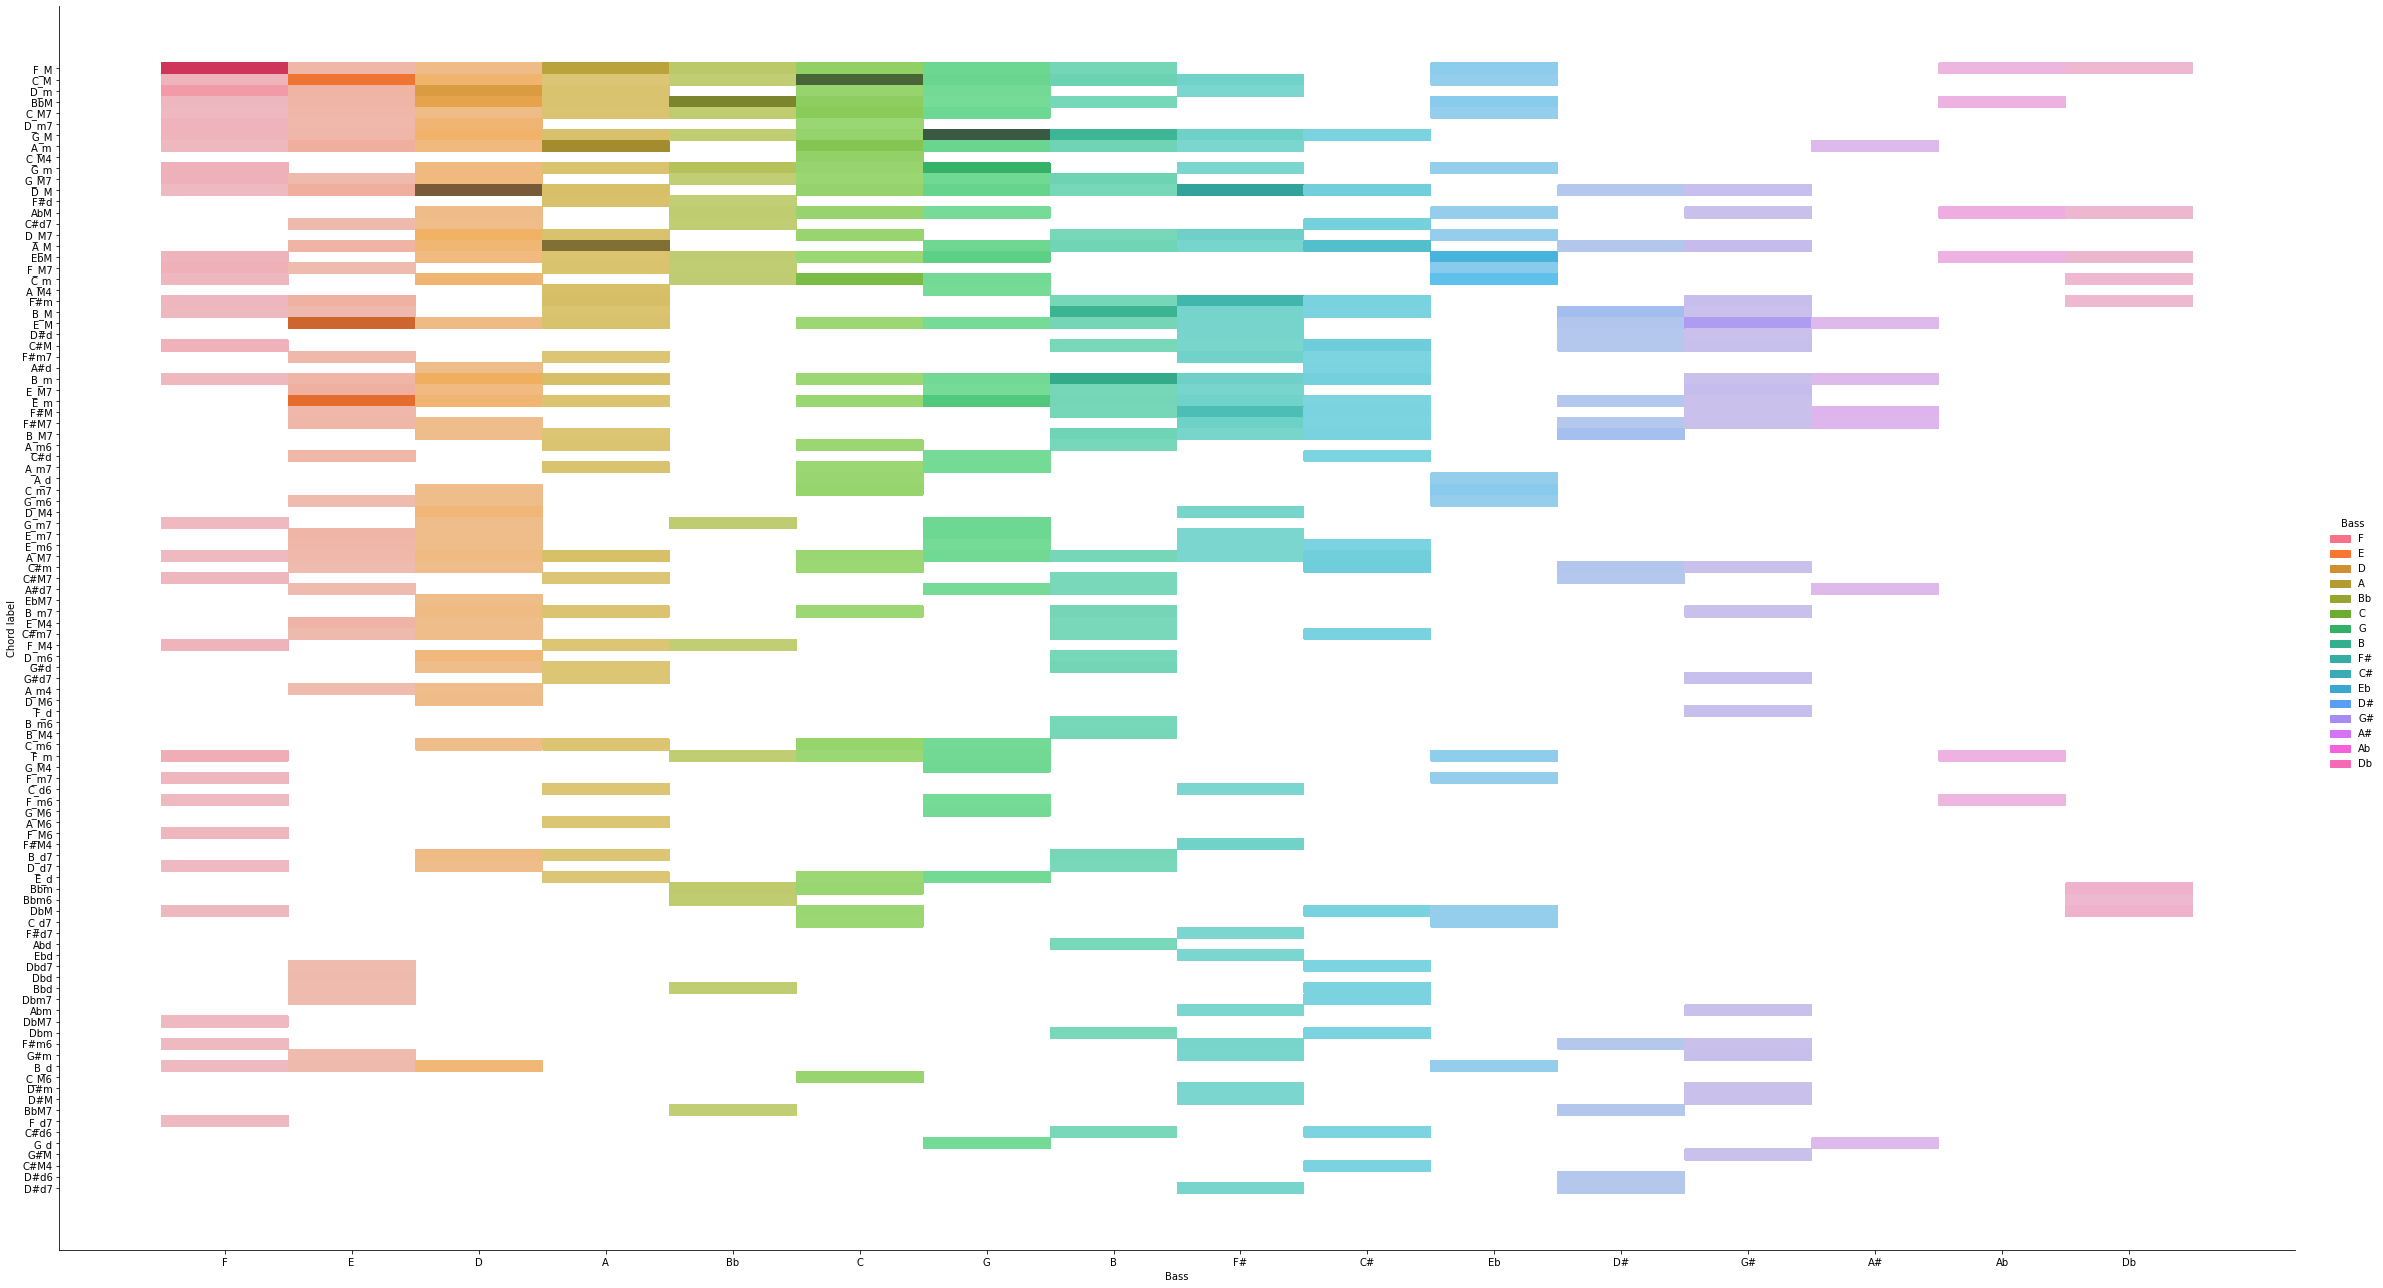

In [ ]:
#fig, ax = plt.subplots(figsize=(30,30))

sns.displot(data=choral_df, x="Bass", y="Chord label", hue="Bass", height=18, aspect=1.8)

#ax.tick_params(axis='y', labelrotation=45)

In [ ]:
choral_df['Chord label'].mode()
columns = choral_df.columns[-3:]
for column in columns:
  print(choral_df[column].mode())

0    D
dtype: object
0    3
dtype: int64
0    D_M
dtype: object


# 03 - Preparação dos dados - Entrega de relatório a respeito da preparação dos dados

# Como a base é muito desbalanceada, vamos criar duas bases além da original,  para fazermos comparações dos modelos com as diferentes bases.

**A primeira** vai ter oversampling das classes minoritárias.

**A segunda** vai ter undersampling das classe majoritárias e oversampling das classes minoritárias.

Decidimos fazer um undersampling para 143 amostras das classes com muitos exemplos e um oversampling para 55 amostras das classes com poucos exemplos.

In [ ]:
oversampling_df = choral_df.drop(columns=['Choral ID', 'Event number'])



# Abaixo vamos verificar que classes tem poucas amostras e fazer o **oversampling**.

Para classes minoritárias com mais de 27 amostras, fazemos o oversampling sem repetição das amostras, para evitar repetição exagerada de um mesmo exemplo. Já para as que tem menos de 27 amostras, não temos como fazer o ovesampling sem repeti-las.

In [ ]:
def oversample(n, df_samples, df_total, replace):
  samples = df_samples.sample(n, replace=replace)
  dfs = [df_total, samples]
  return pd.concat(dfs)

for chord_label in df_freq_perc.index.values:
  n_samples = df_freq_perc.loc[chord_label][0]
  aux_df_samples = oversampling_df.loc[oversampling_df['Chord label'] == chord_label]
  if n_samples < 55 and n_samples > 27:
    aux_n = int(55 - n_samples)
    replace = False
    oversampling_df = oversample(aux_n, aux_df_samples, oversampling_df, replace)
  elif n_samples < 55 and n_samples <= 27:
    aux_n = int(55 - n_samples)
    replace = True
    oversampling_df = oversample(aux_n, aux_df_samples, oversampling_df, replace)





In [ ]:
chords_frequencies = oversampling_df['Chord label'].value_counts()
chords_percentages = oversampling_df['Chord label'].value_counts(normalize = True) * 100
over_freq_perc = pd.DataFrame({'frequency': chords_frequencies, 'percentage (%)': chords_percentages})

# Como podemos ver abaixo, agora todas as classes tem no mínimo 55 amostras

In [ ]:
over_freq_perc

,frequency,percentage (%)
D_M,503,5.441367
G_M,489,5.289918
C_M,488,5.279100
F_M,389,4.208135
A_M,352,3.807875
...,...,...
E_m6,55,0.594981
E_m7,55,0.594981
G_m7,55,0.594981
D_M4,55,0.594981


# Agora vamos verificar que classes tem muitas amostras e fazer o **undersampling**.

Para evitar remover informações cruciais, não vamos reduzir as classes majoritárias para 55 exemplos também. Decidimos reduzir para 143 amostras.

In [ ]:
def undersample(n, df_samples):
  return df_samples.sample(n)

undersample_df = oversampling_df.copy(deep=True)

temp_df = pd.DataFrame()
for chord_label in df_freq_perc.index.values:
  n_samples = df_freq_perc.loc[chord_label][0]
  aux_df_samples = undersample_df.loc[oversampling_df['Chord label'] == chord_label]
  if n_samples > 143:
    aux_under = undersample(143, aux_df_samples)
    
    aux_dfs = [temp_df, aux_under]
    temp_df = pd.concat(aux_dfs, ignore_index=True)
  else:
    aux_dfs = [temp_df, aux_df_samples]
    temp_df = pd.concat(aux_dfs, ignore_index=True)
    
undersample_df = temp_df

# Como podemos observar, agora todas as classes tem no mínimo 55 amostras e no máximo 143 amostras

In [ ]:
chords_frequencies = undersample_df['Chord label'].value_counts()
chords_percentages = undersample_df['Chord label'].value_counts(normalize = True) * 100
under_freq_perc = pd.DataFrame({'frequency': chords_frequencies, 'percentage (%)': chords_percentages})
under_freq_perc

,frequency,percentage (%)
D_M,143,2.023203
G_M,143,2.023203
B_M,143,2.023203
F#m,143,2.023203
C_m,143,2.023203
...,...,...
F#d,55,0.778155
E_M4,55,0.778155
C#d7,55,0.778155
D_M4,55,0.778155


#Continuando da análise exploratória anterior

Vamos remover as colunas ***Choral ID*** e ***Event number***  do original por não terem relação com o problema (nos dataframes de undersample e oversample já foi feito anteriormente). Depois separamos em atributos e repostas e seguiremos com a normalização dos dados

In [ ]:
treated_oversample_df = oversampling_df.drop(columns=['Chord label'])
oversample_chords = oversampling_df['Chord label']

treated_undersample_df = undersample_df.drop(columns=['Chord label'])
undersample_chords = undersample_df['Chord label']

treated_original_df = choral_df.drop(columns=['Choral ID', 'Event number', 'Chord label'])
original_chords = choral_df['Chord label']


Agora vamos conveter os atributos booleanos ***Pitch classe*** em 0 e 1, para padronizar os dados para os modelos.

In [ ]:
pitch_columns = treated_original_df.columns[:-2]

for pitch in pitch_columns:
  treated_original_df[pitch] = treated_original_df[pitch].eq('YES').mul(1)
  treated_undersample_df[pitch] = treated_undersample_df[pitch].eq('YES').mul(1)
  treated_oversample_df[pitch] = treated_oversample_df[pitch].eq('YES').mul(1)

Em seguida vamos converter o atributo categóricos ***Bass*** (16 categorias) utilizando o método ```get_dummies``` do pandas.

In [ ]:
treated_original_df = pd.get_dummies(treated_original_df, columns=['Bass'])
treated_undersample_df = pd.get_dummies(treated_undersample_df, columns=['Bass'])
treated_oversample_df = pd.get_dummies(treated_oversample_df, columns=['Bass'])

In [ ]:
column_names = treated_original_df.columns
column_names

Index(['Pitch classe: C ', 'Pitch classe: C#/Db ', 'Pitch classe: D ',
       'Pitch classe: D# ', 'Pitch classe: E', 'Pitch classe: F ',
       'Pitch classe: F#', 'Pitch classe: G', 'Pitch classe: G#',
       'Pitch classe: A', 'Pitch classe: A#', 'Pitch classe: B', 'Meter',
       'Bass_A', 'Bass_A#', 'Bass_Ab', 'Bass_B', 'Bass_Bb', 'Bass_C',
       'Bass_C#', 'Bass_D', 'Bass_D#', 'Bass_Db', 'Bass_E', 'Bass_Eb',
       'Bass_F', 'Bass_F#', 'Bass_G', 'Bass_G#'],
      dtype='object')

 Normalizando o atributo ***Meter*** (varia de 1 até 5).

In [ ]:
minmax_scaler = MinMaxScaler()
treated_original_array = minmax_scaler.fit_transform(treated_original_df) # now it's a numpy array, not a pandas df
treated_undersample_array = minmax_scaler.fit_transform(treated_undersample_df) # now it's a numpy array, not a pandas df
treated_oversample_array = minmax_scaler.fit_transform(treated_oversample_df) # now it's a numpy array, not a pandas df

treated_original_df = pd.DataFrame(treated_original_array)
treated_undersample_df = pd.DataFrame(treated_undersample_array)
treated_oversample_df = pd.DataFrame(treated_oversample_array)


In [ ]:
treated_original_df.columns = column_names
treated_undersample_df.columns = column_names
treated_oversample_df.columns = column_names

treated_original_df.to_csv('/content/treated_og_choral.csv')
treated_undersample_df.to_csv('/content/treated_us_choral.csv')
treated_oversample_df.to_csv('/content/treated_os_choral.csv')

# Dessa forma obtemos 3 datasets normalizados para serem aplicados nos modelos.

In [ ]:
#treated_original_df
#treated_undersample_df
treated_oversample_df

,Pitch classe: C,Pitch classe: C#/Db,Pitch classe: D,Pitch classe: D#,Pitch classe: E,Pitch classe: F,Pitch classe: F#,Pitch classe: G,Pitch classe: G#,Pitch classe: A,...,Bass_C#,Bass_D,Bass_D#,Bass_Db,Bass_E,Bass_Eb,Bass_F,Bass_F#,Bass_G,Bass_G#
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9239,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9240,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9241,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9242,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# 04 - Variação paramétrica - Relatório sobre evoluções da variação paramétrica



K-NN, LVQ, Árvore de decisão simples, SVM, Random Forest, Rede Neural MLP e um Comitê de Redes Neurais e um comitê heterogêneo

In [ ]:
from numpy.random.mtrand import shuffle
X_orig = treated_original_df
Y_orig = original_chords

#6. Divisao da base de dados em treinamento, validacao e teste
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, Y_orig, test_size=.2, random_state=seed_value)

X_over = treated_oversample_df
Y_over = oversample_chords

#6. Divisao da base de dados em treinamento, validacao e teste
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_over, Y_over, test_size=.2, random_state=seed_value)

X_under = treated_undersample_df
Y_under = undersample_chords

#6. Divisao da base de dados em treinamento, validacao e teste
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_under, Y_under, test_size=.2, random_state=seed_value)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed_value)

# Busca por parâmetros

Para definição dos parâemtros, utilizaremos o método ```RandomizedSearchCV``` do módulo scikit-learn, usando como métrica a acurácia. Além disso, utilizaremos o K-fold estratificado com 10 splits para a validação cruzada.

Inicialmente faremos a busca utilizando somente a base de dados original. No próximo passo faremos comparações com as duas bases geradas, com undersampling e oversampling.

# K-NN
Para k-NN, vamos buscar o melhor número de vizinhos; o melhor peso (uniforme ou baseado na distância); e a melhor métrica de distância a ser utilizada.

In [ ]:
knn = KNeighborsClassifier()
# defining parameter range for knn
param_grid = {'n_neighbors': [n for n in range(1,100)],
              'weights':['uniform', 'distance'],
              'metric':['mahalanobis', 'minkowski', 'euclidean', 'chebyshev']}

# define random search for SVM
search = RandomizedSearchCV(knn, param_grid, n_iter=10, scoring='accuracy', n_jobs=4, cv=cv, random_state=seed_value)

# execute search
result_knn = search.fit(X_train_orig, y_train_orig)

# summarize result for SVM
print('=========Random Search Results for k-NN==========')
print('Best Score: %s' % result_knn.best_score_)
print('Best Hyperparameters: %s' % result_knn.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  UserWarning,


=========Random Search Results for k-NN==========
Best Score: 0.7460211414845718
Best Hyperparameters: {'weights': 'distance', 'n_neighbors': 70, 'metric': 'minkowski'}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [0.74359483        nan        nan        nan        nan 0.72064601
 0.74271183 0.74602114        nan 0.70719141]
  category=UserWarning,


Nessa primeira exploração, encontramos que os melhores parâmetros foram: 70 vizinhos, distância de minkowski e e peso baseado na distância, com acurácia de 74.6%.

#Árvore de decisão

Para Árvore de decisão, vamos variar: o critério de divisão; o número de amostras mínimos para dividir um nó interno; a profundidade máxima da árvore; o número mínimo de amostras nas folhas.

In [ ]:
decisionTree = DecisionTreeClassifier()

# define search space for decision tree
space = dict()
space['criterion'] = ['gini', 'entropy']
space['min_samples_split'] = [2,3,4,5,6,7,8,9]
space['max_depth'] = [3,5,6,7,9,11,13,15,17,19,20,21,22,23,24,25]
space['min_samples_leaf'] = [2,3,4,5,6]

# define random search for decision tree
search = RandomizedSearchCV(decisionTree, space, n_iter=50, scoring='accuracy', n_jobs=4, cv=cv, random_state=seed_value)

# execute search
result_tree = search.fit(X_train_orig, y_train_orig)

# summarize result for decision tree
print('=========Random Search Results fro TREE==========')
print('Best Score: %s' % result_tree.best_score_)
print('Best Hyperparameters: %s' % result_tree.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  UserWarning,


=========Random Search Results fro TREE==========
Best Score: 0.7305807587206192
Best Hyperparameters: {'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 17, 'criterion': 'entropy'}


Os melhores hiperparâmetros encontrados foram: min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 13, 'criterion': 'entropy'; com acurácia de 73.06%



# LVQ

Foi utilizado o algoritmo LVQ generalizado

In [ ]:
lvq = GLVQ()
# defining parameter range for LVQ
param_grid = {"distance_type":["euclidean", "squared-euclidean"],
              "solver_type":['sgd', 'wgd', 'adam', 'lbfgs'], #, 'lbfgs', 'bfgs'
              "activation_type":['identity', 'sigmoid'],
              "prototype_n_per_class": [1,2,3,4,5],
              }

# define random search for LVQ
search = RandomizedSearchCV(lvq, param_grid, n_iter=10, scoring='accuracy', n_jobs=-1, cv=cv, random_state=seed_value)

# execute search
result_lvq = search.fit(X_train_orig, y_train_orig)

# summarize result for LVQ
print('=========Random Search Results for LVQ==========')
print('Best Score: %s' % result_lvq.best_score_)
print('Best Hyperparameters: %s' % result_lvq.best_params_)

=========Random Search Results for LVQ==========
Best Score: 0.7266028726745827
Best Hyperparameters: {'solver_type': 'lbfgs', 'prototype_n_per_class': 4, 'distance_type': 'squared-euclidean', 'activation_type': 'sigmoid'}


#Resultados LVQ
Obtivemos o melhor resultado com os seguintes parâmetros: 'solver_type': 'lbfgs', 'prototype_n_per_class': 4, 'distance_type': 'squared-euclidean', 'activation_type': 'sigmoid'.

A acurácia foi de 72.66%

#SVM

Para SVM será variado: C, gamma, e o tipo de kernel a ser utilizado.

In [ ]:
svc = SVC()
# defining parameter range for svm
param_grid = {'C': [0.1, 1, 10,],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid',]}


# define random search for SVM
search = RandomizedSearchCV(svc, param_grid, n_iter=10, scoring='accuracy', n_jobs=4, cv=cv, random_state=seed_value)

# execute search
result_svc = search.fit(X_train_orig, y_train_orig)

# summarize result for SVM
print('=========Random Search Results for SVM==========')
print('Best Score: %s' % result_svc.best_score_)
print('Best Hyperparameters: %s' % result_svc.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  UserWarning,


=========Random Search Results for SVM==========
Best Score: 0.7376369966255313
Best Hyperparameters: {'kernel': 'rbf', 'gamma': 1, 'C': 1}


Os melhores hiperparâmetros encontrados foram: 'kernel': 'rbf', 'gamma': 1, 'C': 1; com acurácia de 73.76%

# MLP

Para MLP variamos a quantidade de neurônios na camada escondida e quantidade de cmamadas escondidas, além da função de ativação, solver e taxa de aprendizagem alfa.

In [ ]:
mlp = MLPClassifier()
# defining parameter range for MLP
layer_details = [(10,),
                 (20,),
                 (30,),
                 (10,10,),
                 (20,20,),
                 (30,30,),
                 (10,10,10,),
                 (20,20,20,),
                 (30,30,30,),
                 (10,10,10,10,),
                 (20,20,20,20,),
                 (30,30,30,30,),
                 (10,10,10,10,10,),
                 (20,20,20,20,20,),
                 (30,30,30,30,30,)]
param_grid = {'activation':['identity', 'logistic', 'tanh', 'relu'],
              'hidden_layer_sizes':layer_details,
              'solver':['lbfgs', 'sgd', 'adam'],
              'alpha':[1., .1, .01, .001, .0001, .00001],}


# define random search for MLP
search = RandomizedSearchCV(mlp, param_grid, n_iter=10, scoring='accuracy', n_jobs=4, cv=cv, random_state=seed_value)

# execute search
result_mlp = search.fit(X_train_orig, y_train_orig)

# summarize result for MLP
print('=========Random Search Results for MLP==========')
print('Best Score: %s' % result_mlp.best_score_)
print('Best Hyperparameters: %s' % result_mlp.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  UserWarning,


=========Random Search Results for MLP==========
Best Score: 0.7389614999367895
Best Hyperparameters: {'solver': 'lbfgs', 'hidden_layer_sizes': (30, 30, 30), 'alpha': 1.0, 'activation': 'relu'}


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Os melhores parâmetros encontrados foram 'solver': 'lbfgs', 'hidden_layer_sizes': (30, 30, 30), 'alpha': 1.0, 'activation': 'relu'; com acurária de 73.9%.

Apesar disso, como usando solver lbfgs não convergeu, precisamos analisar isso melhor no próximo passo.

# Random Forest

Para Rando Forest vamos variar somente o número de árvores que compõem o comitê.

In [ ]:
RFC = RandomForestClassifier()
# defining parameter range for RFC
param_grid = {'n_estimators': [n for n in range(1,50)],}

# define random search for RFc
search = RandomizedSearchCV(RFC, param_grid, n_iter=10, scoring='accuracy', n_jobs=4, cv=cv, random_state=seed_value)

# execute search
result_rfc = search.fit(X_train_orig, y_train_orig)

# summarize result for RFC
print('=========Random Search Results for RFC==========')
print('Best Score: %s' % result_rfc.best_score_)
print('Best Hyperparameters: %s' % result_rfc.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  UserWarning,


=========Random Search Results for RFC==========
Best Score: 0.7506539856658012
Best Hyperparameters: {'n_estimators': 31}


Enctonramos que o melhor número de membros do comitê foi de 31 árvores com acurácia de 75.06%

#Comitê de RNA

Fizemos um comitê utilizando bagging com MLPs.
Vamos utilizar os parâmetros do melhor resultado para MLP encontrando anteriormente e vamos variar a quantidade de MLPs que vão compor o comitê.

In [ ]:
BMLP = BaggingClassifier()
# defining parameter range for BMLP
param_grid = {'base_estimator':[result_mlp.best_estimator_],
              'n_estimators':[n for n in range(1,10)],}

# define random search for BMLP
search = RandomizedSearchCV(BMLP, param_grid, n_iter=10, scoring='accuracy', n_jobs=4, cv=cv, random_state=seed_value)

# execute search
result_bmlp = search.fit(X_train_orig, y_train_orig)

# summarize result for BMLP
print('=========Random Search Results for BLMP==========')
print('Best Score: %s' % result_bmlp.best_score_)
print('Best Hyperparameters: %s' % result_bmlp.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

=========Random Search Results for BLMP==========
Best Score: 0.754401882700742
Best Hyperparameters: {'n_estimators': 9, 'base_estimator': MLPClassifier(alpha=1.0, hidden_layer_sizes=(30, 30, 30), solver='lbfgs')}


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Mais uma vez não convergiu, porém o melhor número de estimadores foi 9, com 75.44% de acurácia.

# Resumindo

Nesse primeiro momento observamos os desempenhos utilizando somente a base de dados original. os resultados encontrados foram:

- 75.44%: Bagging de MLPs
- 75.06%: Random Forest Classifier
- 74.6%: k-NN
- 73.9%: Multi-Layer Perceptron
- 73.76%: Support Vector Machine
- 73.08%: Árvore de decisão

Na próxima exploração vamos verificar o comportamento dos modelos com as bases tratadas com undersampling e oversampling, comparando com os resultados obtidos usando a base original.

# 05 - Variação paramétrica - Relatório sobre evoluções da variação paramétrica (parte 2)

Fazendo a busca de parâmetros com os outros bancos de dados.

O banco ***oversample*** representa o banco de dados onde só aumentamos artificialmente as amostras de classes com poucos exemplos.

Já o banco ***undersample*** representa o banco de dados onde aumentamos o artificialmente o número de amostras de classes pouco representadas e também diminuímos o número de amostras de classes com muitos exemplos.


K-NN
---

oversample





In [ ]:
knn = KNeighborsClassifier()
# defining parameter range for knn
param_grid = {'n_neighbors': [n for n in range(1,100)],
              'weights':['uniform', 'distance'],
              'metric':['mahalanobis', 'minkowski', 'euclidean', 'chebyshev']}

# define random search for SVM
search = RandomizedSearchCV(knn, param_grid, n_iter=10, scoring='accuracy', n_jobs=4, cv=cv, random_state=seed_value)

# execute search
result_knn_over = search.fit(X_train_over, y_train_over)

# summarize result for SVM
print('=========Random Search Results for k-NN==========')
print('Best Score: %s' % result_knn_over.best_score_)
print('Best Hyperparameters: %s' % result_knn_over.best_params_)

=========Random Search Results for k-NN==========
Best Score: 0.8044592765973009
Best Hyperparameters: {'weights': 'distance', 'n_neighbors': 82, 'metric': 'minkowski'}


Com  ***oversample*** encontramos uma acurácia de 80.45%, com os seguintes parâmetros: ```'weights': 'distance', 'n_neighbors': 82, 'metric': 'minkowski'```

---

undersample

In [ ]:
knn = KNeighborsClassifier()
# defining parameter range for knn
param_grid = {'n_neighbors': [n for n in range(1,100)],
              'weights':['uniform', 'distance'],
              'metric':['mahalanobis', 'minkowski', 'euclidean', 'chebyshev']}

# define random search for SVM
search = RandomizedSearchCV(knn, param_grid, n_iter=10, scoring='accuracy', n_jobs=4, cv=cv, random_state=seed_value)

# execute search
result_knn_under = search.fit(X_train_under, y_train_under)

# summarize result for SVM
print('=========Random Search Results for k-NN==========')
print('Best Score: %s' % result_knn_under.best_score_)
print('Best Hyperparameters: %s' % result_knn_under.best_params_)

=========Random Search Results for k-NN==========
Best Score: 0.7997864223396604
Best Hyperparameters: {'weights': 'distance', 'n_neighbors': 90, 'metric': 'euclidean'}


Já com ***undersample***, obtivemos uma acurácia de 79.98% com os seguintes parâmetros: ```'weights': 'distance', 'n_neighbors': 90, 'metric': 'euclidean'```

Árvore de decisão
---

oversample

In [ ]:
decisionTree = DecisionTreeClassifier()

# define search space for decision tree
space = dict()
space['criterion'] = ['gini', 'entropy']
space['min_samples_split'] = [2,3,4,5,6,7,8,9]
space['max_depth'] = [3,5,6,7,9,11,13,15,17,19,20,21,22,23,24,25]
space['min_samples_leaf'] = [2,3,4,5,6]

# define random search for decision tree
search = RandomizedSearchCV(decisionTree, space, n_iter=50, scoring='accuracy', n_jobs=4, cv=cv, random_state=seed_value)

# execute search
result_tree_over = search.fit(X_train_over, y_train_over)

# summarize result for decision tree
print('=========Random Search Results fro TREE==========')
print('Best Score: %s' % result_tree_over.best_score_)
print('Best Hyperparameters: %s' % result_tree_over.best_params_)

=========Random Search Results fro TREE==========
Best Score: 0.7853913250192004
Best Hyperparameters: {'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 21, 'criterion': 'gini'}


Utilizando a base ***oversample*** obtivemos 78.54% de acurácia com os seguintes parâmetros: ```'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 21, 'criterion': 'gini'```

---

undersample

In [ ]:
decisionTree = DecisionTreeClassifier()

# define search space for decision tree
space = dict()
space['criterion'] = ['gini', 'entropy']
space['min_samples_split'] = [2,3,4,5,6,7,8,9]
space['max_depth'] = [3,5,6,7,9,11,13,15,17,19,20,21,22,23,24,25]
space['min_samples_leaf'] = [2,3,4,5,6]

# define random search for decision tree
search = RandomizedSearchCV(decisionTree, space, n_iter=50, scoring='accuracy', n_jobs=4, cv=cv, random_state=seed_value)

# execute search
result_tree_under = search.fit(X_train_under, y_train_under)

# summarize result for decision tree
print('=========Random Search Results fro TREE==========')
print('Best Score: %s' % result_tree_under.best_score_)
print('Best Hyperparameters: %s' % result_tree_under.best_params_)

=========Random Search Results fro TREE==========
Best Score: 0.7863454141780544
Best Hyperparameters: {'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 13, 'criterion': 'entropy'}


Para ***undersample***, conseguimos 78.63% de acurácia utilizando os seguintes parâmetros: ```'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 13, 'criterion': 'entropy'```

LVQ
---

oversample

In [ ]:
lvq = GLVQ()
# defining parameter range for LVQ
param_grid = {"distance_type":["euclidean", "squared-euclidean"],
              "solver_type":['sgd', 'wgd', 'adam', 'lbfgs'], #, 'lbfgs', 'bfgs'
              "activation_type":['identity', 'sigmoid'],
              "prototype_n_per_class": [1,2,3,4,5],
              }

# define random search for LVQ
search = RandomizedSearchCV(lvq, param_grid, n_iter=10, scoring='accuracy', n_jobs=-1, cv=cv, random_state=seed_value)

# execute search
result_lvq_over = search.fit(X_train_over, y_train_over)

# summarize result for LVQ
print('=========Random Search Results for LVQ==========')
print('Best Score: %s' % result_lvq_over.best_score_)
print('Best Hyperparameters: %s' % result_lvq_over.best_params_)

=========Random Search Results for LVQ==========
Best Score: 0.7528001682331859
Best Hyperparameters: {'solver_type': 'lbfgs', 'prototype_n_per_class': 4, 'distance_type': 'squared-euclidean', 'activation_type': 'sigmoid'}


Com ***oversample*** obtivemos 75.28% de acurácia com parâmetros: ```'solver_type': 'lbfgs', 'prototype_n_per_class': 4, 'distance_type': 'squared-euclidean', 'activation_type': 'sigmoid'```

---

undersample

In [ ]:
lvq = GLVQ()
# defining parameter range for LVQ
param_grid = {"distance_type":["euclidean", "squared-euclidean"],
              "solver_type":['sgd', 'wgd', 'adam', 'lbfgs'], #, 'lbfgs', 'bfgs'
              "activation_type":['identity', 'sigmoid'],
              "prototype_n_per_class": [1,2,3,4,5],
              }

# define random search for LVQ
search = RandomizedSearchCV(lvq, param_grid, n_iter=10, scoring='accuracy', n_jobs=-1, cv=cv, random_state=seed_value)

# execute search
result_lvq_under = search.fit(X_train_under, y_train_under)

# summarize result for LVQ
print('=========Random Search Results for LVQ==========')
print('Best Score: %s' % result_lvq_under.best_score_)
print('Best Hyperparameters: %s' % result_lvq_under.best_params_)

=========Random Search Results for LVQ==========
Best Score: 0.7504362237718503
Best Hyperparameters: {'solver_type': 'lbfgs', 'prototype_n_per_class': 4, 'distance_type': 'squared-euclidean', 'activation_type': 'sigmoid'}


Já com ***undersample***, temos 75.04% de acurácia com parâmetros: ```'solver_type': 'lbfgs', 'prototype_n_per_class': 4, 'distance_type': 'squared-euclidean', 'activation_type': 'sigmoid'```

SVM
---

oversample

In [ ]:
svc = SVC()
# defining parameter range for svm
param_grid = {'C': [0.1, 1, 10,],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid',]}


# define random search for SVM
search = RandomizedSearchCV(svc, param_grid, n_iter=10, scoring='accuracy', n_jobs=4, cv=cv, random_state=seed_value)

# execute search
result_svc_over = search.fit(X_train_over, y_train_over)

# summarize result for SVM
print('=========Random Search Results for SVM==========')
print('Best Score: %s' % result_svc_over.best_score_)
print('Best Hyperparameters: %s' % result_svc_over.best_params_)

=========Random Search Results for SVM==========
Best Score: 0.7698372526789307
Best Hyperparameters: {'kernel': 'rbf', 'gamma': 1, 'C': 1}


Para ***oversample*** conseguimos 76.98% de acurácia, para parâmetros: ```'kernel': 'rbf', 'gamma': 1, 'C': 1```

---

undersample

In [ ]:
svc = SVC()
# defining parameter range for svm
param_grid = {'C': [0.1, 1, 10,],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid',]}


# define random search for SVM
search = RandomizedSearchCV(svc, param_grid, n_iter=10, scoring='accuracy', n_jobs=4, cv=cv, random_state=seed_value)

# execute search
result_svc_under = search.fit(X_train_under, y_train_under)

# summarize result for SVM
print('=========Random Search Results for SVM==========')
print('Best Score: %s' % result_svc_under.best_score_)
print('Best Hyperparameters: %s' % result_svc_under.best_params_)

=========Random Search Results for SVM==========
Best Score: 0.7679442759310798
Best Hyperparameters: {'kernel': 'rbf', 'gamma': 1, 'C': 1}


Para ***undersample*** temos acurácia de 76.79% com parâmetros ```'kernel': 'rbf', 'gamma': 1, 'C': 1```

MLP
---

oversample

In [ ]:
mlp = MLPClassifier()
# defining parameter range for MLP
layer_details = [(10,),
                 (20,),
                 (30,),
                 (10,10,),
                 (20,20,),
                 (30,30,),
                 (10,10,10,),
                 (20,20,20,),
                 (30,30,30,),
                 (10,10,10,10,),
                 (20,20,20,20,),
                 (30,30,30,30,),
                 (10,10,10,10,10,),
                 (20,20,20,20,20,),
                 (30,30,30,30,30,)]
param_grid = {'activation':['identity', 'logistic', 'tanh', 'relu'],
              'hidden_layer_sizes':layer_details,
              'solver':['lbfgs', 'sgd', 'adam'],
              'alpha':[1., .1, .01, .001, .0001, .00001],}


# define random search for MLP
search = RandomizedSearchCV(mlp, param_grid, n_iter=10, scoring='accuracy', n_jobs=4, cv=cv, random_state=seed_value)

# execute search
result_mlp_over = search.fit(X_train_over, y_train_over)

# summarize result for MLP
print('=========Random Search Results for MLP==========')
print('Best Score: %s' % result_mlp_over.best_score_)
print('Best Hyperparameters: %s' % result_mlp_over.best_params_)

=========Random Search Results for MLP==========
Best Score: 0.7860684635921442
Best Hyperparameters: {'solver': 'lbfgs', 'hidden_layer_sizes': (30, 30, 30), 'alpha': 1.0, 'activation': 'relu'}


Para ***oversample*** temos acurácia de 78.61% com parâmetros ```'solver': 'lbfgs', 'hidden_layer_sizes': (30, 30, 30), 'alpha': 1.0, 'activation': 'relu```

undersample

In [ ]:
mlp = MLPClassifier()
# defining parameter range for MLP
layer_details = [(10,),
                 (20,),
                 (30,),
                 (10,10,),
                 (20,20,),
                 (30,30,),
                 (10,10,10,),
                 (20,20,20,),
                 (30,30,30,),
                 (10,10,10,10,),
                 (20,20,20,20,),
                 (30,30,30,30,),
                 (10,10,10,10,10,),
                 (20,20,20,20,20,),
                 (30,30,30,30,30,)]
param_grid = {'activation':['identity', 'logistic', 'tanh', 'relu'],
              'hidden_layer_sizes':layer_details,
              'solver':['lbfgs', 'sgd', 'adam'],
              'alpha':[1., .1, .01, .001, .0001, .00001],}


# define random search for MLP
search = RandomizedSearchCV(mlp, param_grid, n_iter=10, scoring='accuracy', n_jobs=4, cv=cv, random_state=seed_value)

# execute search
result_mlp_under = search.fit(X_train_under, y_train_under)

# summarize result for MLP
print('=========Random Search Results for MLP==========')
print('Best Score: %s' % result_mlp_under.best_score_)
print('Best Hyperparameters: %s' % result_mlp_under.best_params_)

=========Random Search Results for MLP==========
Best Score: 0.7854626473623315
Best Hyperparameters: {'solver': 'lbfgs', 'hidden_layer_sizes': (30, 30, 30), 'alpha': 1.0, 'activation': 'relu'}


Para ***undersample*** temos acurácia de 78.55% com parâmetros ```'solver': 'lbfgs', 'hidden_layer_sizes': (30, 30, 30), 'alpha': 1.0, 'activation': 'relu```

RFC
---

oversample

In [ ]:
RFC = RandomForestClassifier()
# defining parameter range for RFC
param_grid = {'n_estimators': [n for n in range(1,50)],}

# define random search for RFc
search = RandomizedSearchCV(RFC, param_grid, n_iter=10, scoring='accuracy', n_jobs=4, cv=cv, random_state=seed_value)

# execute search
result_rfc_over = search.fit(X_train_over, y_train_over)

# summarize result for RFC
print('=========Random Search Results for RFC==========')
print('Best Score: %s' % result_rfc_over.best_score_)
print('Best Hyperparameters: %s' % result_rfc_over.best_params_)

=========Random Search Results for RFC==========
Best Score: 0.8077050799107633
Best Hyperparameters: {'n_estimators': 47}


Para ***oversample*** temos acurácia de 80.08% com parâmetro: ```'n_estimators': 47```

undersample

In [ ]:
RFC = RandomForestClassifier()
# defining parameter range for RFC
param_grid = {'n_estimators': [n for n in range(1,50)],}

# define random search for RFc
search = RandomizedSearchCV(RFC, param_grid, n_iter=10, scoring='accuracy', n_jobs=4, cv=cv, random_state=seed_value)

# execute search
result_rfc_under = search.fit(X_train_under, y_train_under)

# summarize result for RFC
print('=========Random Search Results for RFC==========')
print('Best Score: %s' % result_rfc_under.best_score_)
print('Best Hyperparameters: %s' % result_rfc_under.best_params_)

=========Random Search Results for RFC==========
Best Score: 0.802258357046812
Best Hyperparameters: {'n_estimators': 15}


Para ***undersample*** temos acurácia de 80.23% com parâmetro: ```'n_estimators': 15```

Bagging RNA
---

oversample

In [ ]:
BMLP = BaggingClassifier()
# defining parameter range for BMLP
param_grid = {'base_estimator':[result_mlp_over.best_estimator_],
              'n_estimators':[n for n in range(1,10)],}

# define random search for BMLP
search = RandomizedSearchCV(BMLP, param_grid, n_iter=10, scoring='accuracy', n_jobs=4, cv=cv, random_state=seed_value)

# execute search
result_bmlp_over = search.fit(X_train_over, y_train_over)

# summarize result for BMLP
print('=========Random Search Results for BLMP==========')
print('Best Score: %s' % result_bmlp_over.best_score_)
print('Best Hyperparameters: %s' % result_bmlp_over.best_params_)

=========Random Search Results for BLMP==========
Best Score: 0.7978325348352412
Best Hyperparameters: {'n_estimators': 9, 'base_estimator': MLPClassifier(alpha=1.0, hidden_layer_sizes=(30, 30, 30), solver='lbfgs')}


Para ***oversample*** temos acurácia de 79.78% com parâmetro: ```'n_estimators': 9, 'base_estimator': MLPClassifier(alpha=1.0, hidden_layer_sizes=(30, 30, 30), solver='lbfgs')```

undersample

In [ ]:
BMLP = BaggingClassifier()
# defining parameter range for BMLP
param_grid = {'base_estimator':[result_mlp_under.best_estimator_],
              'n_estimators':[n for n in range(1,10)],}

# define random search for BMLP
search = RandomizedSearchCV(BMLP, param_grid, n_iter=10, scoring='accuracy', n_jobs=4, cv=cv, random_state=seed_value)

# execute search
result_bmlp_under = search.fit(X_train_under, y_train_under)

# summarize result for BMLP
print('=========Random Search Results for BLMP==========')
print('Best Score: %s' % result_bmlp_under.best_score_)
print('Best Hyperparameters: %s' % result_bmlp_under.best_params_)

=========Random Search Results for BLMP==========
Best Score: 0.7996097438944307
Best Hyperparameters: {'n_estimators': 7, 'base_estimator': MLPClassifier(alpha=1.0, hidden_layer_sizes=(30, 30, 30), solver='lbfgs')}


Para ***undersample*** temos acurácia de 79.96% com parâmetro: ```'n_estimators': 7, 'base_estimator': MLPClassifier(alpha=1.0, hidden_layer_sizes=(30, 30, 30), solver='lbfgs')```

# Comitê heterogêneo

Para o comitê heterogêneo, vamos utilizar k-NN, árvores de decisão, MLP, SVM e LVQ.

Primeiro vamos treinar os modelos que irão compor o comitê com os parâmetros encontrados anteriormente.

Como foi feito nos modelos anteriores, iremos treinar utilizando as três bases geradas anteriormente, mas iremos fazer variações com voto simples (**hard**) e votos baseados em probabilidades (**soft**), totalizando 12 comitês para comparações.

**Original**
---

In [ ]:
knn_orig_cmt = KNeighborsClassifier(weights='distance', metric='minkowski', n_neighbors=70)
dt_orig_cmt = DecisionTreeClassifier(min_samples_split=5, min_samples_leaf=3, max_depth=13, criterion='entropy')
mlp_orig_cmt = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(30, 30, 30), alpha=1.0, activation='relu')
svm_orig_cmt = SVC(kernel='rbf', gamma=1, C=1, probability=True)
lvq_orig_cmt = GLVQ(solver_type='lbfgs', prototype_n_per_class=4, distance_type='squared-euclidean', activation_type='sigmoid')

**Hard vote**

In [ ]:
committee_orig_hard = VotingClassifier(estimators=[('dt', dt_orig_cmt), ('knn', knn_orig_cmt), ('mlp', mlp_orig_cmt), ('svm', svm_orig_cmt), ('lvq', lvq_orig_cmt)],
                                       voting='hard')

committee_orig_hard.fit(X_train_orig, y_train_orig)

committee_orig_hard.score(X_test_orig, y_test_orig)

0.7537511032656664

**Soft vote**

In [ ]:
#.fit(X_train_orig, y_train_orig)

committee_orig_soft = VotingClassifier(estimators=[('dt', dt_orig_cmt), ('knn', knn_orig_cmt), ('mlp', mlp_orig_cmt), ('svm', svm_orig_cmt), ('lvq', lvq_orig_cmt)],
                                  voting='soft')

committee_orig_soft.fit(X_train_orig, y_train_orig)

committee_orig_soft.score(X_test_orig, y_test_orig)

0.7608120035304501

**Oversampling**
---

In [ ]:
knn_over_cmt = KNeighborsClassifier(weights='distance', n_neighbors=82, metric='minkowski')
dt_over_cmt = DecisionTreeClassifier(min_samples_split=3, min_samples_leaf=2, max_depth=21, criterion='gini')
mlp_over_cmt = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(30, 30, 30), alpha=1.0, activation='relu')
svm_over_cmt = SVC(kernel='rbf', gamma=1, C=1, probability=True)
lvq_over_cmt = GLVQ(solver_type='lbfgs', prototype_n_per_class=4, distance_type='squared-euclidean', activation_type='sigmoid')

**Hard vote**

In [ ]:
committee_over_hard = VotingClassifier(estimators=[('dt', dt_over_cmt), ('knn', knn_over_cmt), ('mlp', mlp_over_cmt), ('svm', svm_over_cmt), ('lvq', lvq_over_cmt)],
                                  voting='hard')

committee_over_hard.fit(X_train_over, y_train_over)

committee_over_hard.score(X_test_over, y_test_over)

0.7934018388318009

**Soft vote**

In [ ]:
committee_over_soft = VotingClassifier(estimators=[('dt', dt_over_cmt), ('knn', knn_over_cmt), ('mlp', mlp_over_cmt), ('svm', svm_over_cmt), ('lvq', lvq_over_cmt)],
                                  voting='soft')

committee_over_soft.fit(X_train_over, y_train_over)

committee_over_soft.score(X_test_over, y_test_over)

0.8074634937804218

**Undersampling**
---

In [ ]:
knn_under_cmt = KNeighborsClassifier(weights='distance', n_neighbors=90, metric='euclidean')
dt_under_cmt = DecisionTreeClassifier(min_samples_split=3, min_samples_leaf=2, max_depth=13, criterion='entropy')
mlp_under_cmt = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(30, 30, 30), alpha=1.0, activation='relu')
svm_under_cmt = SVC(kernel='rbf', gamma=1, C=1, probability=True)
lvq_under_cmt = GLVQ(solver_type='lbfgs', prototype_n_per_class=4, distance_type='squared-euclidean', activation_type='sigmoid')

**Hard vote**

In [ ]:
committee_under_hard = VotingClassifier(estimators=[('dt', dt_under_cmt), ('knn', knn_under_cmt), ('mlp', mlp_under_cmt), ('svm', svm_under_cmt), ('lvq', lvq_under_cmt)],
                                  voting='hard')

committee_under_hard.fit(X_train_under, y_train_under)

committee_under_hard.score(X_test_under, y_test_under)

0.804101838755304

**Soft vote**

In [ ]:
committee_under_soft = VotingClassifier(estimators=[('dt', dt_under_cmt), ('knn', knn_under_cmt), ('mlp', mlp_under_cmt), ('svm', svm_under_cmt), ('lvq', lvq_under_cmt)],
                                  voting='soft')

committee_under_soft.fit(X_train_under, y_train_under)

committee_under_soft.score(X_test_under, y_test_under)

0.8076379066478077

**Análise rápida das métricas obtidas na primeira e segunda variação paramétrica**
---

In [ ]:
            # k-nn,             dt,                 lvq,                svm,                mlp,                rfc,                crna,              chethard,           chetsoft 
orig_acc = [0.7460211414845718, 0.7305807587206192, 0.7266028726745827, 0.7376369966255313, 0.7389614999367895, 0.7506539856658012, 0.754401882700742, 0.7537511032656664, 0.7608120035304501]
np.mean(orig_acc)

0.7443802494005283

In [ ]:
            # k-nn,             dt,                 lvq,                svm,                mlp,                rfc,                crna,              chethard,           chetsoft 
over_acc = [0.8044592765973009, 0.7853913250192004, 0.7528001682331859, 0.7698372526789307, 0.7860684635921442, 0.8077050799107633, 0.7978325348352412, 0.7934018388318009, 0.8074634937804218]
np.mean(over_acc)

0.789439937053221

In [ ]:
            # k-nn,             dt,                 lvq,                svm,                mlp,                rfc,                crna,              chethard,           chetsoft 
under_acc = [0.7997864223396604, 0.7863454141780544, 0.7504362237718503, 0.7679442759310798, 0.7854626473623315, 0.802258357046812, 0.7996097438944307, 0.804101838755304, 0.8076379066478077]
np.mean(under_acc)

0.7892869811030366

Como podemos observar acima, a acurácia média dos métodos com o banco de dados original ficou em 74.44%, já com o banco **oversample** ficou 78.94% e com o banco **undersample** temos 78.93%. Dessa forma obtivemos um **ganho de médio de 4.5% na acurácia** quando utilizamos as bases mais balanceadas.

Quando comparando somente entre mesmos modelos, vimos alguns casos com aumento na acurácia maior que 5%.

Dessa forma,
---
conseguimos demonstrar que com a criação de novas bases de dados mais balanceadas fomos capazes de melhorar os resultados obtidos, em alguns casos obtendo acurácia superior à 80%.

Os próximos passos incluem: 
* realizar testes dos modelos para comparar quais são estatisticamente diferentes.
* plotar gráficos das métricas obtidas para ajudar na visualização das informações para o relatório final e identificar se mais informações podem ser extraídas.

---

# Testes estatisticos

Vamos utilizar o teste de Friedman para verificar se o os modelos são estatísticamente iguais ($H_0$) ou diferentes ($H_1$). Para os casos que rejeitam $H_0$, podemos verificar qual modelo é estatiscamente melhor que o outro utilizando o teste de Nemenyi.

Vamos utilizar Acurácia como métrica, Precisão, Recall e F-measure (ou F1 score).

Abaixo vamos capturar essas métricas utilizando os parâmetros econtrados nas estapas anteriores. Será utilizada validação cruzada utilizando *Stratified* $K$ *fold*, com $K = 10$



In [ ]:
scorings = ['accuracy', 'precision_micro', 'recall_micro', 'f1_micro']

In [ ]:
KNN_orig = KNeighborsClassifier(n_neighbors=70, metric='minkowski',weights='distance')
DT_orig = DecisionTreeClassifier(min_samples_split=5, min_samples_leaf=3, max_depth=13, criterion='entropy', random_state=seed_value)
LVQ_orig = GLVQ(solver_type='lbfgs', prototype_n_per_class=4,distance_type='squared-euclidean', activation_type='sigmoid', random_state=seed_value)
SVM_orig = SVC(kernel='rbf', gamma=1, C=1, probability=True, random_state=seed_value)
MLP_orig = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(30, 30, 30), alpha=1.0, activation='relu', random_state=seed_value)
RFC_orig = RandomForestClassifier(n_estimators=31, n_jobs = -1, random_state=seed_value)
BMLP_orig = BaggingClassifier(n_estimators=9, base_estimator=MLPClassifier(alpha=1.0, hidden_layer_sizes=(30, 30, 30)), random_state=seed_value)

knn_orig_cmt = KNeighborsClassifier(weights='distance', metric='minkowski', n_neighbors=70)
dt_orig_cmt = DecisionTreeClassifier(min_samples_split=5, min_samples_leaf=3, max_depth=13, criterion='entropy', random_state=seed_value)
mlp_orig_cmt = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(30, 30, 30), alpha=1.0, activation='relu', random_state=seed_value)
svm_orig_cmt = SVC(kernel='rbf', gamma=1, C=1, probability=True, random_state=seed_value)
lvq_orig_cmt = GLVQ(solver_type='lbfgs', prototype_n_per_class=4,distance_type='squared-euclidean', activation_type='sigmoid', random_state=seed_value)


HETC_orig = VotingClassifier(estimators=[('dt', dt_orig_cmt), ('knn', knn_orig_cmt),
                                         ('mlp', mlp_orig_cmt), ('svm', svm_orig_cmt),
                                         ('lvq', lvq_orig_cmt)], 
                             voting='hard')

In [ ]:
models_orig = []
models_orig.append(('KNN', KNN_orig))
models_orig.append(('DT', DT_orig))
models_orig.append(('SVM', SVM_orig))
models_orig.append(('LVQ', LVQ_orig))
models_orig.append(('MLP', MLP_orig))
models_orig.append(('RFC', RFC_orig))
models_orig.append(('BMLP', BMLP_orig))
models_orig.append(('HETC', HETC_orig))

results_orig = {}

for scoring in scorings:
  aux_results = []
  print('scoring: %s' % scoring)
  for name, model in models_orig:
    cv_results = cross_val_score(model, X_train_orig, y_train_orig, cv=cv, scoring=scoring, n_jobs=-1)
    aux_results.append(cv_results)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
  results_orig['scoring'] = aux_results
  print()


scoring: accuracy
KNN: 0.746906 (0.010421)
DT: 0.726385 (0.009701)
SVM: 0.737198 (0.019978)
LVQ: 0.723296 (0.018153)
MLP: 0.741385 (0.019097)
RFC: 0.749995 (0.012766)
BMLP: 0.719764 (0.020530)
HETC: 0.751318 (0.016000)

scoring: precision_micro
KNN: 0.746906 (0.010421)
DT: 0.726385 (0.009701)
SVM: 0.737198 (0.019978)
LVQ: 0.723296 (0.018153)
MLP: 0.741385 (0.019097)
RFC: 0.749995 (0.012766)
BMLP: 0.719764 (0.020530)
HETC: 0.751318 (0.016000)

scoring: recall_micro
KNN: 0.746906 (0.010421)
DT: 0.726385 (0.009701)
SVM: 0.737198 (0.019978)
LVQ: 0.723296 (0.018153)
MLP: 0.741385 (0.019097)
RFC: 0.749995 (0.012766)
BMLP: 0.719764 (0.020530)
HETC: 0.751318 (0.016000)

scoring: f1_micro
KNN: 0.746906 (0.010421)
DT: 0.726385 (0.009701)
SVM: 0.737198 (0.019978)
LVQ: 0.723296 (0.018153)
MLP: 0.741385 (0.019097)
RFC: 0.749995 (0.012766)
BMLP: 0.719764 (0.020530)
HETC: 0.751318 (0.016000)



Oversample
---

In [ ]:
KNN_over = KNeighborsClassifier(n_neighbors=82, metric='minkowski',weights='distance')
DT_over = DecisionTreeClassifier(min_samples_split=3, min_samples_leaf=2, max_depth=21, criterion='gini', random_state=seed_value)
LVQ_over = GLVQ(solver_type='lbfgs', prototype_n_per_class=4, distance_type='squared-euclidean', activation_type='sigmoid', random_state=seed_value)
SVM_over = SVC(kernel='rbf', gamma=1, C=1, probability=True, random_state=seed_value)
MLP_over = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(30, 30, 30), alpha=1.0, activation='relu', random_state=seed_value)
RFC_over = RandomForestClassifier(n_estimators=47, random_state=seed_value)
BMLP_over = BaggingClassifier(n_estimators=9, base_estimator=MLPClassifier(alpha=1.0, hidden_layer_sizes=(30, 30, 30)), random_state=seed_value)

knn_over_cmt = KNeighborsClassifier(n_neighbors=82, metric='minkowski',weights='distance')
dt_over_cmt = DecisionTreeClassifier(min_samples_split=3, min_samples_leaf=2, max_depth=21, criterion='gini', random_state=seed_value)
mlp_over_cmt = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(30, 30, 30), alpha=1.0, activation='relu', random_state=seed_value)
svm_over_cmt = SVC(kernel='rbf', gamma=1, C=1, probability=True, random_state=seed_value)
lvq_over_cmt = GLVQ(solver_type='lbfgs', prototype_n_per_class=4, distance_type='squared-euclidean', activation_type='sigmoid', random_state=seed_value)


HETC_over = VotingClassifier(estimators=[('dt', dt_over_cmt), ('knn', knn_over_cmt),
                                         ('mlp', mlp_over_cmt), ('svm', svm_over_cmt),
                                         ('lvq', lvq_over_cmt)], 
                             voting='hard')

In [ ]:
models_over = []
models_over.append(('KNN', KNN_over))
models_over.append(('DT', DT_over))
models_over.append(('SVM', SVM_over))
models_over.append(('LVQ', LVQ_over))
models_over.append(('MLP', MLP_over))
models_over.append(('RFC', RFC_over))
models_over.append(('BMLP', BMLP_over))
models_over.append(('HETC', HETC_over))

results_over = {}

for scoring in scorings:
  aux_results = []
  print('scoring: %s' % scoring)
  for name, model in models_over:
    cv_results = cross_val_score(model, X_train_over, y_train_over, cv=cv, scoring=scoring, n_jobs=-1)
    aux_results.append(cv_results)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
  results_over['scoring'] = aux_results
  print()

scoring: accuracy
KNN: 0.804057 (0.014383)
DT: 0.784177 (0.013533)
SVM: 0.774841 (0.015706)
LVQ: 0.749013 (0.013880)
MLP: 0.790531 (0.013330)
RFC: 0.805949 (0.014773)
BMLP: 0.726026 (0.015013)
HETC: 0.797293 (0.014252)

scoring: precision_micro
KNN: 0.804057 (0.014383)
DT: 0.784177 (0.013533)
SVM: 0.774841 (0.015706)
LVQ: 0.749013 (0.013880)
MLP: 0.790531 (0.013330)
RFC: 0.805949 (0.014773)
BMLP: 0.726026 (0.015013)
HETC: 0.797293 (0.014252)

scoring: recall_micro
KNN: 0.804057 (0.014383)
DT: 0.784177 (0.013533)
SVM: 0.774841 (0.015706)
LVQ: 0.749013 (0.013880)
MLP: 0.790531 (0.013330)
RFC: 0.805949 (0.014773)
BMLP: 0.726026 (0.015013)
HETC: 0.797293 (0.014252)

scoring: f1_micro
KNN: 0.804057 (0.014383)
DT: 0.784177 (0.013533)
SVM: 0.774841 (0.015706)
LVQ: 0.749013 (0.013880)
MLP: 0.790531 (0.013330)
RFC: 0.805949 (0.014773)
BMLP: 0.726026 (0.015013)
HETC: 0.797293 (0.014252)



Undersample
---

In [ ]:
KNN_under = KNeighborsClassifier(n_neighbors=90, metric='euclidean',weights='distance')
DT_under = DecisionTreeClassifier(min_samples_split=3, min_samples_leaf=2, max_depth=13, criterion='entropy', random_state=seed_value)
LVQ_under = GLVQ(solver_type='lbfgs', prototype_n_per_class=4, distance_type='squared-euclidean', activation_type='sigmoid', random_state=seed_value)
SVM_under = SVC(kernel='rbf', gamma=1, C=1, probability=True, random_state=seed_value)
MLP_under = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(30, 30, 30), alpha=1.0, activation='relu', random_state=seed_value)
RFC_under = RandomForestClassifier(n_estimators=15, random_state=seed_value)
BMLP_under = BaggingClassifier(n_estimators=7, base_estimator=MLPClassifier(alpha=1.0, hidden_layer_sizes=(30, 30, 30)), random_state=seed_value)

knn_under_cmt = KNeighborsClassifier(n_neighbors=90, metric='euclidean',weights='distance')
dt_under_cmt = DecisionTreeClassifier(min_samples_split=3, min_samples_leaf=2, max_depth=13, criterion='entropy', random_state=seed_value)
mlp_under_cmt = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(30, 30, 30), alpha=1.0, activation='relu', random_state=seed_value)
svm_under_cmt = SVC(kernel='rbf', gamma=1, C=1, probability=True, random_state=seed_value)
lvq_under_cmt = GLVQ(solver_type='lbfgs', prototype_n_per_class=4, distance_type='squared-euclidean', activation_type='sigmoid', random_state=seed_value)


HETC_under = VotingClassifier(estimators=[('dt', dt_under_cmt), ('knn', knn_under_cmt),
                                         ('mlp', mlp_under_cmt), ('svm', svm_under_cmt),
                                         ('lvq', lvq_under_cmt)], 
                             voting='hard')

In [ ]:
models_under = []
models_under.append(('KNN', KNN_under))
models_under.append(('DT', DT_under))
models_under.append(('SVM', SVM_under))
models_under.append(('LVQ', LVQ_under))
models_under.append(('MLP', MLP_under))
models_under.append(('RFC', RFC_under))
models_under.append(('BMLP', BMLP_under))
models_under.append(('HETC', HETC_under))

results_under = {}

for scoring in scorings:
  aux_results = []
  print('scoring: %s' % scoring)
  for name, model in models_under:
    cv_results = cross_val_score(model, X_train_under, y_train_under, cv=cv, scoring=scoring, n_jobs=-1)
    aux_results.append(cv_results)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
  results_under['scoring'] = aux_results
  print()

scoring: accuracy
KNN: 0.797143 (0.014951)
DT: 0.782815 (0.016142)
SVM: 0.767784 (0.023634)
LVQ: 0.751863 (0.016181)
MLP: 0.790246 (0.018737)
RFC: 0.798736 (0.020521)
BMLP: 0.723556 (0.017031)
HETC: 0.794667 (0.017455)

scoring: precision_micro
KNN: 0.797143 (0.014951)
DT: 0.782815 (0.016142)
SVM: 0.767784 (0.023634)
LVQ: 0.751863 (0.016181)
MLP: 0.790246 (0.018737)
RFC: 0.798736 (0.020521)
BMLP: 0.723556 (0.017031)
HETC: 0.794667 (0.017455)

scoring: recall_micro
KNN: 0.797143 (0.014951)
DT: 0.782815 (0.016142)
SVM: 0.767784 (0.023634)
LVQ: 0.751863 (0.016181)
MLP: 0.790246 (0.018737)
RFC: 0.798736 (0.020521)
BMLP: 0.723556 (0.017031)
HETC: 0.794667 (0.017455)

scoring: f1_micro
KNN: 0.797143 (0.014951)
DT: 0.782815 (0.016142)
SVM: 0.767784 (0.023634)
LVQ: 0.751863 (0.016181)
MLP: 0.790246 (0.018737)
RFC: 0.798736 (0.020521)
BMLP: 0.723556 (0.017031)
HETC: 0.794667 (0.017455)



# Testes estatísticos

Comparando os modelos com os dados originais

In [ ]:
                    # acc,      f1,     recall,      precision
knn_orig_metrics = [0.746906, 0.743379, 0.725228, 0.730002]
dt_orig_metrics = [0.726385, 0.717827, 0.728373, 0.727322]
svm_orig_metrics = [0.737198, 0.710092, 0.734771, 0.703079]
lvq_orig_metrics = [0.726165, 0.723655, 0.725506, 0.737044]
mlp_orig_metrics = [0.742710, 0.725115, 0.734331, 0.731564]
rfc_orig_metrics = [0.749995, 0.730779, 0.740732, 0.737724]
bmlp_orig_metrics = [0.719764, 0.678839, 0.718664, 0.656275]
hetc_orig_metrics = [0.753084, 0.734637, 0.749115, 0.738453]

#combine three groups into one array
data_class = np.array([knn_orig_metrics, 
                       dt_orig_metrics,
                       svm_orig_metrics,
                       lvq_orig_metrics,
                       mlp_orig_metrics,
                       rfc_orig_metrics,
                       bmlp_orig_metrics,
                       hetc_orig_metrics])



testResult = stats.friedmanchisquare(data_class[0], data_class[1], data_class[2], data_class[3], data_class[4], data_class[5], data_class[6], data_class[7])

print("Resultado = {}".format(testResult))

sp.posthoc_nemenyi_friedman(data_class.T)

Resultado = FriedmanchisquareResult(statistic=21.0, pvalue=0.003770150051146164)


,0,1,2,3,4,5,6,7
0,1.000000,0.900000,0.900000,0.900000,0.900000,0.900000,0.288368,0.730216
1,0.900000,1.000000,0.900000,0.900000,0.900000,0.469509,0.900000,0.156455
2,0.900000,0.900000,1.000000,0.900000,0.900000,0.557628,0.816508,0.215676
3,0.900000,0.900000,0.900000,1.000000,0.900000,0.643922,0.730216,0.288368
4,0.900000,0.900000,0.900000,0.900000,1.000000,0.900000,0.288368,0.730216
5,0.900000,0.469509,0.557628,0.643922,0.900000,1.000000,0.020322,0.900000
6,0.288368,0.900000,0.816508,0.730216,0.288368,0.020322,1.000000,0.002470
7,0.730216,0.156455,0.215676,0.288368,0.730216,0.900000,0.002470,1.000000


Comparando os modelos após fazer oversample das clases minoritárias

In [ ]:
                    # acc,      f1,     recall,      precision
knn_over_metrics = [0.803512, 0.786221, 0.795267, 0.802863]
dt_over_metrics = [0.783229, 0.768007, 0.777011, 0.784355]
svm_over_metrics = [0.776871, 0.762255, 0.773090, 0.784100]
lvq_over_metrics = [0.752664, 0.745939, 0.751724, 0.771342]
mlp_over_metrics = [0.792554, 0.780651, 0.787018, 0.794976]
rfc_over_metrics = [0.804865, 0.791390, 0.799053, 0.806178]
bmlp_over_metrics = [0.725214, 0.708373, 0.725220, 0.726941]
hetc_over_metrics = [0.799995, 0.787206, 0.795402, 0.803631]

#combine three groups into one array
data_class = np.array([knn_over_metrics, 
                       dt_over_metrics,
                       svm_over_metrics,
                       lvq_over_metrics,
                       mlp_over_metrics,
                       rfc_over_metrics,
                       bmlp_over_metrics,
                       hetc_over_metrics])



testResult = stats.friedmanchisquare(data_class[0], data_class[1], data_class[2], data_class[3], data_class[4], data_class[5], data_class[6], data_class[7])

print("Resultado = {}".format(testResult))

sp.posthoc_nemenyi_friedman(data_class.T)

Resultado = FriedmanchisquareResult(statistic=27.75, pvalue=0.0002440472551294392)


,0,1,2,3,4,5,6,7
0,1.000000,0.900000,0.557628,0.215676,0.900000,0.900000,0.049967,0.900000
1,0.900000,1.000000,0.900000,0.900000,0.900000,0.288368,0.643922,0.730216
2,0.557628,0.900000,1.000000,0.900000,0.900000,0.075544,0.900000,0.374603
3,0.215676,0.900000,0.900000,1.000000,0.643922,0.012452,0.900000,0.110246
4,0.900000,0.900000,0.900000,0.643922,1.000000,0.643922,0.288368,0.900000
5,0.900000,0.288368,0.075544,0.012452,0.643922,1.000000,0.001374,0.900000
6,0.049967,0.643922,0.900000,0.900000,0.288368,0.001374,1.000000,0.020322
7,0.900000,0.730216,0.374603,0.110246,0.900000,0.900000,0.020322,1.000000


Comparando os modelos após fazer oversamplme das classes minoritárias **e** undersample das classes majoritárias

In [ ]:
                    # acc,      f1,     recall,      precision
knn_under_metrics = [0.799614, 0.783553, 0.792715, 0.805304]
dt_under_metrics = [0.779454, 0.767525, 0.776265, 0.789964]
svm_under_metrics = [0.771134, 0.754466, 0.764238, 0.779781]
lvq_under_metrics = [0.753270, 0.749232, 0.759109, 0.772770]
mlp_under_metrics = [0.790244, 0.782555, 0.790415, 0.800761]
rfc_under_metrics = [0.798905, 0.788497, 0.796605, 0.807287]
bmlp_under_metrics = [0.729042, 0.716935, 0.730277, 0.744659]
hetc_under_metrics = [0.796785, 0.786311, 0.793777, 0.806537]

#combine three groups into one array
data_class = np.array([knn_under_metrics, 
                       dt_under_metrics,
                       svm_under_metrics,
                       lvq_under_metrics,
                       mlp_under_metrics,
                       rfc_under_metrics,
                       bmlp_under_metrics,
                       hetc_under_metrics])



testResult = stats.friedmanchisquare(data_class[0], data_class[1], data_class[2], data_class[3], data_class[4], data_class[5], data_class[6], data_class[7])

print("Resultado = {}".format(testResult))

sp.posthoc_nemenyi_friedman(data_class.T)

Resultado = FriedmanchisquareResult(statistic=27.25, pvalue=0.000300451692719203)


,0,1,2,3,4,5,6,7
0,1.000000,0.816508,0.469509,0.156455,0.900000,0.900000,0.032317,0.900000
1,0.816508,1.000000,0.900000,0.900000,0.900000,0.374603,0.643922,0.730216
2,0.469509,0.900000,1.000000,0.900000,0.900000,0.110246,0.900000,0.374603
3,0.156455,0.900000,0.900000,1.000000,0.643922,0.020322,0.900000,0.110246
4,0.900000,0.900000,0.900000,0.643922,1.000000,0.730216,0.288368,0.900000
5,0.900000,0.374603,0.110246,0.020322,0.730216,1.000000,0.002470,0.900000
6,0.032317,0.643922,0.900000,0.900000,0.288368,0.002470,1.000000,0.020322
7,0.900000,0.730216,0.374603,0.110246,0.900000,0.900000,0.020322,1.000000


Comparando as alterações da base

In [ ]:
# KNN
data_knn = np.array([knn_orig_metrics,
                     knn_over_metrics,
                     knn_under_metrics,])

testResult = stats.friedmanchisquare(data_knn[0], data_knn[1], data_knn[2])

print("Resultado KNN = {}".format(testResult))

print(sp.posthoc_nemenyi_friedman(data_knn.T))

# DT
data_dt = np.array([dt_orig_metrics,
                    dt_over_metrics,
                    dt_under_metrics,])

testResult_dt = stats.friedmanchisquare(data_dt[0], data_dt[1], data_dt[2])

print('---')
print("Resultado DT = {}".format(testResult_dt))

print(sp.posthoc_nemenyi_friedman(data_dt.T))

#SVM
data_svm = np.array([svm_orig_metrics,
                    svm_over_metrics,
                    svm_under_metrics,])

testResult_svm = stats.friedmanchisquare(data_svm[0], data_svm[1], data_svm[2])

print('---')
print("Resultado SVM = {}".format(testResult_svm))

print(sp.posthoc_nemenyi_friedman(data_svm.T))

#LVQ
data_lvq = np.array([lvq_orig_metrics,
                    lvq_over_metrics,
                    lvq_under_metrics,])

testResult_lvq = stats.friedmanchisquare(data_lvq[0], data_lvq[1], data_lvq[2])

print('---')
print("Resultado LVQ = {}".format(testResult_lvq))

print(sp.posthoc_nemenyi_friedman(data_lvq.T))

#MLP
data_mlp = np.array([mlp_orig_metrics,
                    mlp_over_metrics,
                    mlp_under_metrics,])

testResult_mlp = stats.friedmanchisquare(data_mlp[0], data_mlp[1], data_mlp[2])

print('---')
print("Resultado MLP = {}".format(testResult_mlp))

print(sp.posthoc_nemenyi_friedman(data_mlp.T))

#RFC
data_rfc = np.array([rfc_orig_metrics,
                    rfc_over_metrics,
                    rfc_under_metrics,])

testResult_rfc = stats.friedmanchisquare(data_rfc[0], data_rfc[1], data_rfc[2])

print('---')
print("Resultado RFC = {}".format(testResult_rfc))

print(sp.posthoc_nemenyi_friedman(data_rfc.T))

#BMLP
data_bmlp = np.array([bmlp_orig_metrics,
                      bmlp_over_metrics,
                      bmlp_under_metrics,])

testResult_bmlp = stats.friedmanchisquare(data_bmlp[0], data_bmlp[1], data_bmlp[2])

print('---')
print("Resultado BMLP = {}".format(testResult_bmlp))

print(sp.posthoc_nemenyi_friedman(data_bmlp.T))

#HETC
data_hetc = np.array([hetc_orig_metrics,
                      hetc_over_metrics,
                      hetc_under_metrics,])

testResult_hetc = stats.friedmanchisquare(data_hetc[0], data_hetc[1], data_hetc[2])

print('---')
print("Resultado HETC = {}".format(testResult_hetc))

print(sp.posthoc_nemenyi_friedman(data_hetc.T))

Resultado KNN = FriedmanchisquareResult(statistic=6.5, pvalue=0.03877420783172202)
          0         1         2
0  1.000000  0.035567  0.180637
1  0.035567  1.000000  0.739010
2  0.180637  0.739010  1.000000
---
Resultado DT = FriedmanchisquareResult(statistic=6.5, pvalue=0.03877420783172202)
          0         1         2
0  1.000000  0.035567  0.180637
1  0.035567  1.000000  0.739010
2  0.180637  0.739010  1.000000
---
Resultado SVM = FriedmanchisquareResult(statistic=8.0, pvalue=0.018315638888734182)
          0         1         2
0  1.000000  0.012992  0.334141
1  0.012992  1.000000  0.334141
2  0.334141  0.334141  1.000000
---
Resultado LVQ = FriedmanchisquareResult(statistic=8.0, pvalue=0.018315638888734182)
          0         1         2
0  1.000000  0.334141  0.012992
1  0.334141  1.000000  0.334141
2  0.012992  0.334141  1.000000
---
Resultado MLP = FriedmanchisquareResult(statistic=6.5, pvalue=0.03877420783172202)
          0         1         2
0  1.000000  0.180637  0

Como podemos observar pelos resultados obtidos, os modelos treinados com as bases de dados tratadas com oversample e undersample são estatísticamente diferentes dos modelos treinados com a base de dados originais. Porém, comparando entre os modelos gerados com as bases tratadas, não podemos afirmar que são estatísticamente diferentes.

Desa forma, só mostraremos as matrizes de confusão para os modelos treinados com a base de dados marcada como ***oversample***, já que para todas as variações teríamos 24 matrizes para exibir.

# Matrizes de confusão
Base de dados tratadas com *oversample* das classes minoritárias.

In [ ]:
KNN_over = KNeighborsClassifier(n_neighbors=82, metric='minkowski',weights='distance').fit(X_train_over, y_train_over)
DT_over = DecisionTreeClassifier(min_samples_split=3, min_samples_leaf=2, max_depth=21, criterion='gini', random_state=seed_value).fit(X_train_over, y_train_over)
LVQ_over = GLVQ(solver_type='lbfgs', prototype_n_per_class=4, distance_type='squared-euclidean', activation_type='sigmoid', random_state=seed_value).fit(X_train_over, y_train_over)
SVM_over = SVC(kernel='rbf', gamma=1, C=1, probability=True, random_state=seed_value).fit(X_train_over, y_train_over)
MLP_over = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(30, 30, 30), alpha=1.0, activation='relu', random_state=seed_value).fit(X_train_over, y_train_over)
RFC_over = RandomForestClassifier(n_estimators=47, random_state=seed_value).fit(X_train_over, y_train_over)
BMLP_over = BaggingClassifier(n_estimators=9, base_estimator=MLPClassifier(alpha=1.0, hidden_layer_sizes=(30, 30, 30)), random_state=seed_value).fit(X_train_over, y_train_over)

knn_over_cmt = KNeighborsClassifier(n_neighbors=82, metric='minkowski',weights='distance')
dt_over_cmt = DecisionTreeClassifier(min_samples_split=3, min_samples_leaf=2, max_depth=21, criterion='gini', random_state=seed_value)
mlp_over_cmt = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(30, 30, 30), alpha=1.0, activation='relu', random_state=seed_value)
svm_over_cmt = SVC(kernel='rbf', gamma=1, C=1, probability=True, random_state=seed_value)
lvq_over_cmt = GLVQ(solver_type='lbfgs', prototype_n_per_class=4, distance_type='squared-euclidean', activation_type='sigmoid', random_state=seed_value)


HETC_over = VotingClassifier(estimators=[('dt', dt_over_cmt), ('knn', knn_over_cmt),
                                         ('mlp', mlp_over_cmt), ('svm', svm_over_cmt),
                                         ('lvq', lvq_over_cmt)], 
                             voting='hard').fit(X_train_over, y_train_over)

In [ ]:
knn_y = KNN_over.predict(X_test_over)
dt_y = DT_over.predict(X_test_over)
lvq_y = LVQ_over.predict(X_test_over)
svm_y = SVM_over.predict(X_test_over)
mlp_y = MLP_over.predict(X_test_over)
rfc_y = RFC_over.predict(X_test_over)
bmlp_y = BMLP_over.predict(X_test_over)
hetc_y = HETC_over.predict(X_test_over)

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test_over, knn_y))

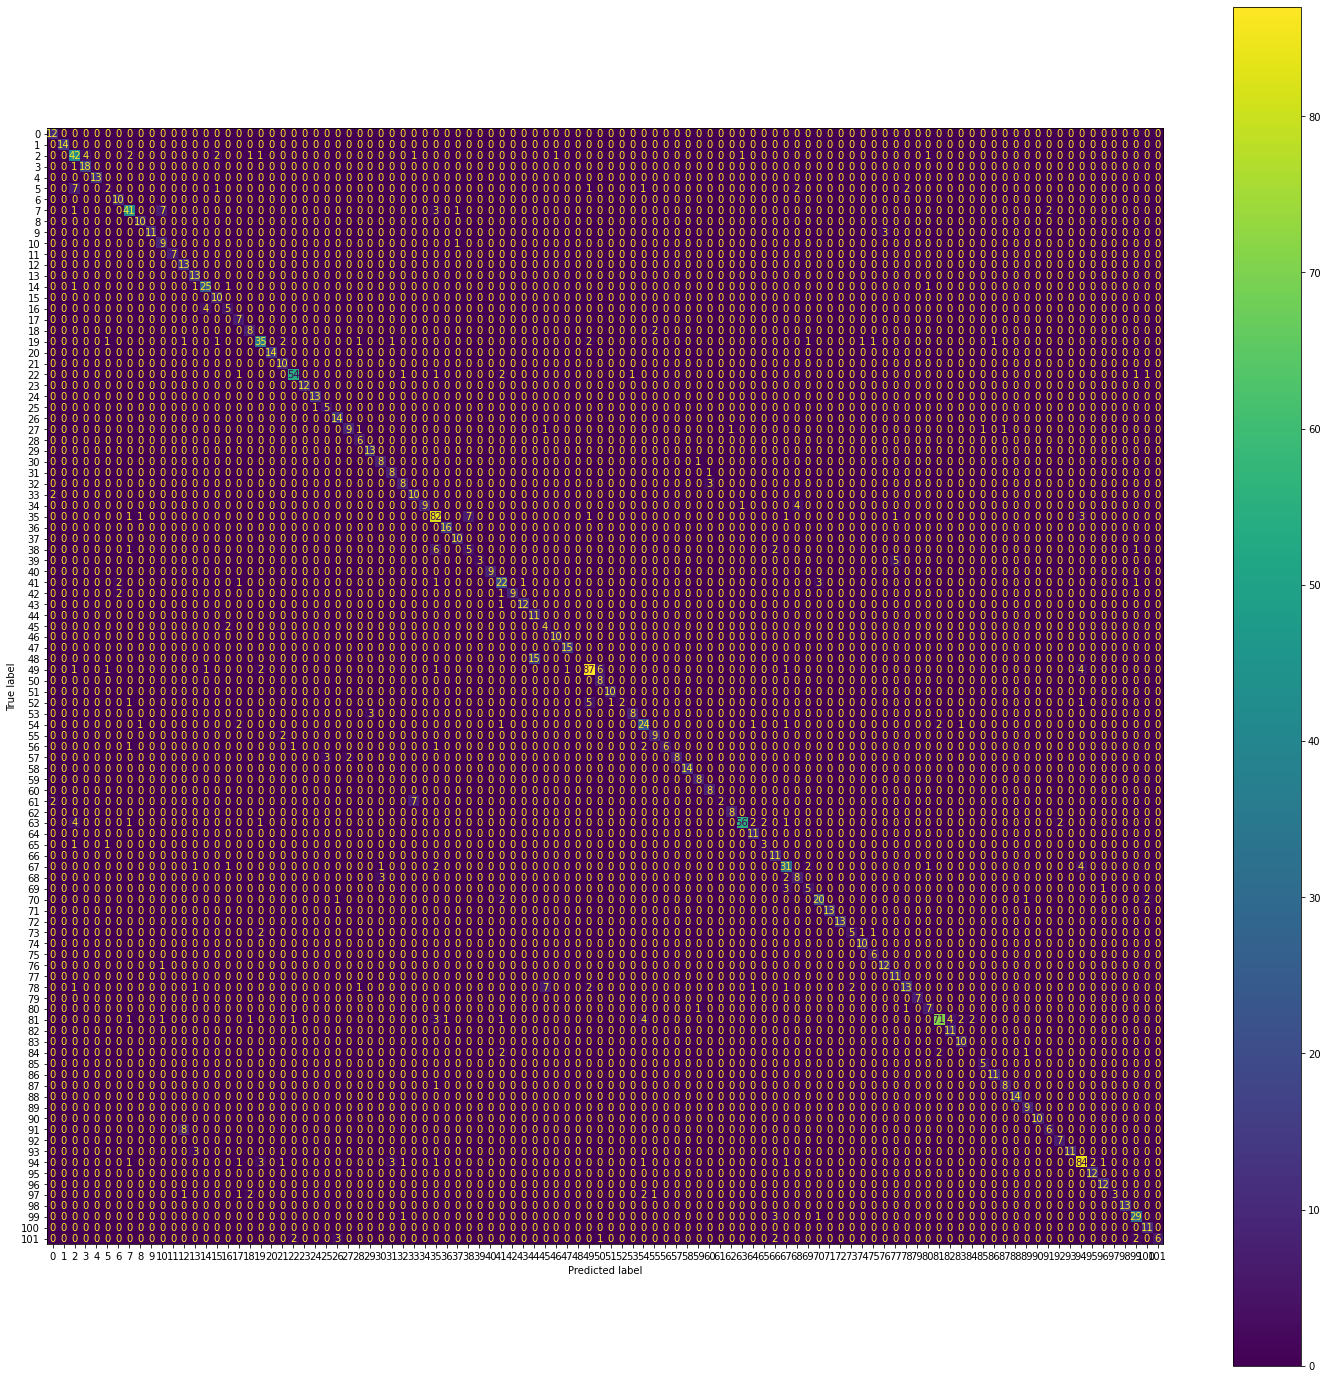

In [ ]:
fig, ax = plt.subplots(figsize=(25,25))
disp.plot(ax=ax)

In [ ]:
print(confusion_matrix(y_test_over, dt_y))

[[12  0  0 ...  0  0  0]
 [ 0 14  0 ...  0  0  0]
 [ 0  0 46 ...  0  0  0]
 ...
 [ 0  0  0 ... 28  0  0]
 [ 0  0  0 ...  0 11  0]
 [ 0  0  0 ...  2  0  6]]


In [ ]:
confusion_matrix(y_test_over, lvq_y)

array([[12,  0,  0, ...,  0,  0,  0],
       [ 0, 14,  0, ...,  0,  0,  0],
       [ 0,  0, 39, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 28,  0,  0],
       [ 0,  0,  0, ...,  0,  6,  0],
       [ 0,  0,  0, ...,  2,  0,  7]])

In [ ]:
confusion_matrix(y_test_over, svm_y)

array([[12,  0,  0, ...,  0,  0,  0],
       [ 0, 14,  0, ...,  0,  0,  0],
       [ 0,  0, 44, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 30,  0,  0],
       [ 0,  0,  0, ...,  0,  6,  0],
       [ 0,  0,  0, ...,  2,  0,  7]])

In [ ]:
confusion_matrix(y_test_over, mlp_y)

array([[12,  0,  0, ...,  0,  0,  0],
       [ 0, 14,  0, ...,  0,  0,  0],
       [ 0,  0, 45, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 30,  0,  1],
       [ 0,  0,  0, ...,  0,  6,  0],
       [ 0,  0,  0, ...,  4,  0,  7]])

In [ ]:
confusion_matrix(y_test_over, rfc_y)

array([[12,  0,  0, ...,  0,  0,  0],
       [ 0, 14,  0, ...,  0,  0,  0],
       [ 0,  0, 43, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 29,  0,  1],
       [ 0,  0,  0, ...,  0, 11,  0],
       [ 0,  0,  0, ...,  4,  0,  7]])

In [ ]:
confusion_matrix(y_test_over, bmlp_y)

array([[12,  0,  0, ...,  0,  0,  0],
       [ 0,  7,  0, ...,  0,  0,  0],
       [ 0,  0, 43, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 27,  0,  1],
       [ 0,  0,  0, ...,  0,  6,  0],
       [ 0,  0,  0, ...,  3,  0,  6]])

In [ ]:
confusion_matrix(y_test_over, hetc_y)

array([[12,  0,  0, ...,  0,  0,  0],
       [ 0, 14,  0, ...,  0,  0,  0],
       [ 0,  0, 45, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 29,  0,  0],
       [ 0,  0,  0, ...,  0,  6,  0],
       [ 0,  0,  0, ...,  2,  0,  7]])

In [ ]:
# KNN original


knn.fit(X_train_orig, y_train_orig)

# KNN oversample

# KNN undersample

In [ ]:
cm_df

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,101
0,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,10,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,25,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,11,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,9,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,0,0,0
99,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,24,0,1
100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,16,0


In [ ]:
classification_report(y_test_under, Y_test_prediction_knn)

'              precision    recall  f1-score   support\n\n         A#d       0.59      1.00      0.74        10\n        A#d7       1.00      1.00      1.00        10\n         A_M       0.74      0.83      0.78        30\n        A_M4       0.92      0.92      0.92        12\n        A_M6       1.00      1.00      1.00         8\n        A_M7       0.80      0.40      0.53        10\n         A_d       0.93      1.00      0.97        14\n         A_m       0.76      0.58      0.66        33\n        A_m4       0.93      1.00      0.97        14\n        A_m6       1.00      0.50      0.67         8\n        A_m7       0.79      0.92      0.85        12\n         AbM       0.91      1.00      0.95        10\n         Abd       0.59      1.00      0.74        13\n         Abm       0.86      1.00      0.92        12\n         B_M       0.88      0.93      0.90        30\n        B_M4       0.64      1.00      0.78         7\n        B_M7       1.00      0.31      0.47        13\n       

In [ ]:
knn_clsf.score(X_test_under, y_test_under)

0.8161244695898161

# Resultados para boxplot

{'boxes': [<matplotlib.lines.Line2D at 0x7f80250d6f90>,
 'caps': [<matplotlib.lines.Line2D at 0x7f802501a890>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f80234d9410>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f80234d32d0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f80234c5890>,
  <matplotlib.lines.Line2D at 0x7f802c462590>]}

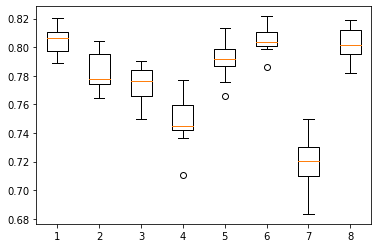

In [ ]:
x = [[0.81081081, 0.80945946, 0.80540541, 0.80540541, 0.82027027, 0.80784844,
      0.81461434, 0.79431664, 0.79296346, 0.78890392],
     [0.79459459, 0.80405405, 0.76486486, 0.77432432, 0.80135135, 0.77401894,
      0.79566982, 0.77537212, 0.77943166, 0.76454668],
     [0.78108108, 0.78648649, 0.79054054, 0.76486486, 0.78108108, 0.78484438,
      0.77131258, 0.76860622, 0.7564276,  0.74966171],
     [0.75135135, 0.76216216, 0.76216216, 0.74189189, 0.77702703, 0.74560217,
      0.74424899, 0.74289581, 0.73612991, 0.71041949],
     [0.81216216, 0.8, 0.78783784, 0.77567568, 0.79459459, 0.78619756,
      0.81326116, 0.79161028, 0.79161028, 0.76589986],
     [0.82162162, 0.81216216, 0.80135135, 0.80675676, 0.81216216, 0.80649526,
      0.80108254, 0.79837618, 0.80108254, 0.78619756],
     [0.73108108, 0.75, 0.73648649, 0.70945946, 0.72837838, 0.71718539,
      0.70365359, 0.71041949, 0.72395129, 0.68335589],
     [0.81351351, 0.80810811, 0.79864865, 0.79459459, 0.81891892, 0.797023,
      0.8173207,  0.8037889,  0.78619756, 0.78213802,]
     ]
     
plt.boxplot(x)
     